## 1. Import data and libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans # Here is where you import the k-means algorithm from scikit-learn.
import pylab as pl # PyLab is a convenience module that bulk imports matplotlib.
os.environ['OMP_NUM_THREADS'] = '3'
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore') 


In [3]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [4]:
# Importing file

df = pd.read_csv(r"C:\Users\zwier\anaconda_projects\6.5\Final_Cleaned_EV_Data.csv")

## 2. Data Cleaning and Preprocessing

In [6]:
# Checking unique 

print(df["region"].unique())
print(df["category"].unique())
print(df["parameter"].unique())
print(df["unit"].unique())
print(df["powertrain"].unique())
print(df["year"].unique())

['Australia' 'Austria' 'Belgium' 'Brazil' 'Bulgaria' 'Canada' 'Chile'
 'China' 'Colombia' 'Costa Rica' 'Croatia' 'Cyprus' 'Czech Republic'
 'Denmark' 'Estonia' 'Finland' 'France' 'Germany' 'Greece' 'Hungary'
 'Iceland' 'India' 'Indonesia' 'Ireland' 'Israel' 'Italy' 'Japan' 'Korea'
 'Latvia' 'Lithuania' 'Luxembourg' 'Mexico' 'Netherlands' 'New Zealand'
 'Norway' 'Poland' 'Portugal' 'Romania' 'Seychelles' 'Slovakia' 'Slovenia'
 'South Africa' 'Spain' 'Sweden' 'Switzerland' 'Thailand' 'Turkiye'
 'United Arab Emirates' 'United Kingdom' 'USA']
['Historical']
['EV stock share' 'EV sales share' 'EV sales' 'EV stock'
 'EV charging points' 'Electricity demand' 'Oil displacement Mbd'
 'Oil displacement, million lge']
['percent' 'Vehicles' 'charging points' 'GWh' 'Milion barrels per day'
 'Oil displacement, million lge']
['EV' 'BEV' 'PHEV' 'Publicly available fast' 'Publicly available slow'
 'FCEV']
[2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2010]


In [7]:
# Filter dataset for electric vehicle stock and sales (EV, BEV only)
selected_params = ['EV stock', 'EV sales']
selected_powertrain = ['EV', 'BEV']

df_filtered = df[(df['parameter'].isin(selected_params)) & (df['powertrain'].isin(selected_powertrain))]

# Keep only necessary columns
df_filtered = df_filtered[['region', 'year', 'parameter', 'value']]

# Pivot table to have parameters as columns
df_pivot = df_filtered.pivot_table(index=['region', 'year'], columns='parameter', values='value').reset_index()

# Check the first rows
df_pivot.head()


parameter,region,year,EV sales,EV stock
0,Australia,2011,49.0,49.0
1,Australia,2012,170.0,220.0
2,Australia,2013,190.0,410.0
3,Australia,2014,370.0,780.0
4,Australia,2015,760.0,1500.0


In [8]:
print(df_pivot.isnull().sum())
print(df_pivot.shape)

parameter
region        0
year          0
EV sales      7
EV stock    139
dtype: int64
(558, 4)


In [9]:
# Fill NaN only in numerical columns
numeric_cols = ['EV sales', 'EV stock']
df_pivot[numeric_cols] = df_pivot[numeric_cols].fillna(df_pivot[numeric_cols].mean())
print(df_pivot.isnull().sum())
print(df_pivot.shape)


parameter
region      0
year        0
EV sales    0
EV stock    0
dtype: int64
(558, 4)


## 3. The elbow technique

Score values: [-1116.0, -268.1206496312376, -106.69856751833174, -62.27941400061624, -40.72067879898515, -24.12157495514154, -17.725645419040646, -14.548752391468263, -9.275499002053952]


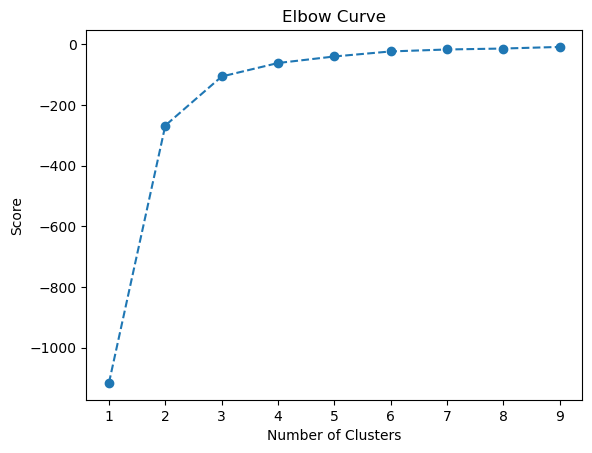

In [48]:
# Scale the numerical columns
scaler = StandardScaler()
df_pivot[['EV sales', 'EV stock']] = scaler.fit_transform(df_pivot[['EV sales', 'EV stock']])

# Define range for potential clusters
num_cl = range(1, 10)

# Apply K-means clustering for different values of k
kmeans = [KMeans(n_clusters=i, init='k-means++', random_state=42) for i in num_cl]

# Compute score for each cluster option
score = [kmeans[i].fit(df_pivot[['EV sales', 'EV stock']]).score(df_pivot[['EV sales', 'EV stock']]) 
         for i in range(len(kmeans))]

# Print score values
print("Score values:", score)

# Plot the elbow curve
pl.plot(num_cl, score, marker='o', linestyle='--')
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()


## 4. Choosing the Optimal Number of Clusters

Based on the **Elbow Method** chart, we can observe that the curve experiences a significant drop between **k=1 and k=3**, after which the decrease becomes more gradual. This "elbow" at **k=3** suggests that **3 clusters is the optimal choice** for our K-means algorithm. 

We choose **k=3** because:
- The score improvement **slows down after k=3**, meaning additional clusters do not add significant value.
- The elbow point is a standard method to **balance accuracy and simplicity** in clustering.
- Adding more clusters beyond this point **wouldn't significantly improve separation**, but would make the model more complex.

Therefore, we proceed with **k=3 for clustering**.

## 5. K-means algorithm & adding new 'clusters' column

In [14]:
# Define the number of clusters based on the elbow method
optimal_clusters = 3  

# Create the K-means object
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)

# Fit the K-means model to the scaled data
df_pivot['clusters'] = kmeans.fit_predict(df_pivot[['EV sales', 'EV stock', 'year']])


# Display the first few rows of the dataset with cluster labels
df_pivot.head()


parameter,region,year,EV sales,EV stock,clusters
0,Australia,2011,-0.181594,-0.229370,0
1,Australia,2012,-0.180269,-0.228727,0
2,Australia,2013,-0.180050,-0.228011,0
3,Australia,2014,-0.178079,-0.226618,0
4,Australia,2015,-0.173808,-0.223907,0


In [15]:
df_pivot['clusters'].value_counts()

clusters
1    225
0    185
2    148
Name: count, dtype: int64

## 6. Visualizations

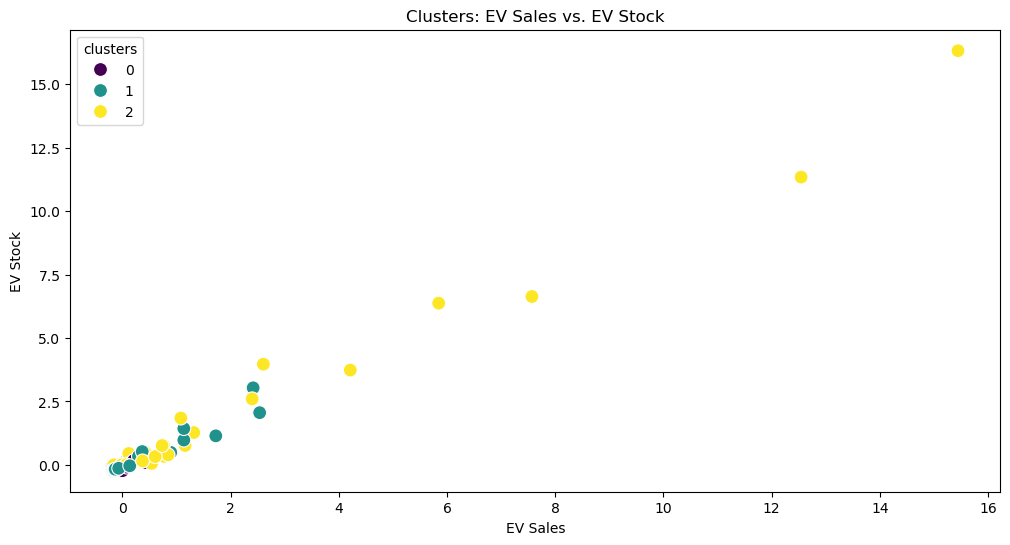

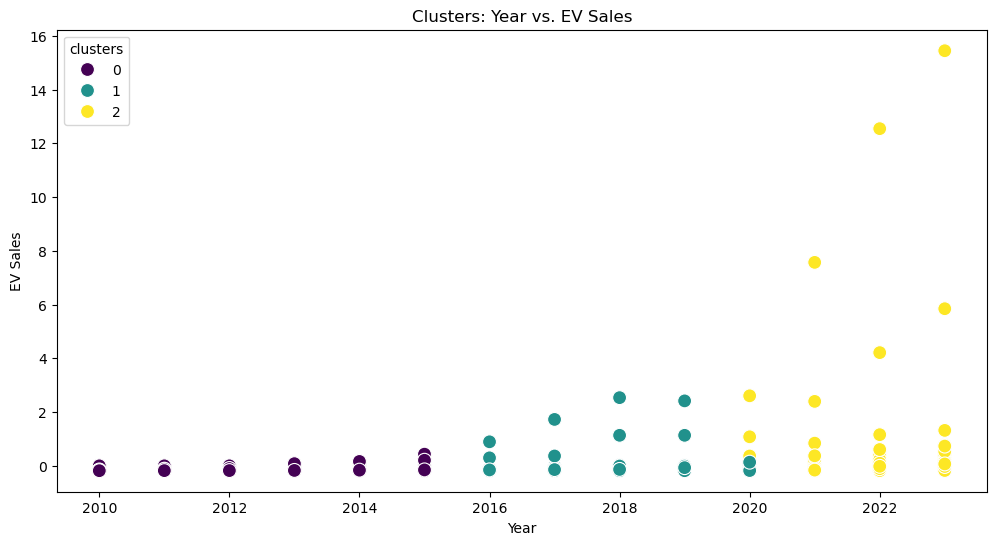

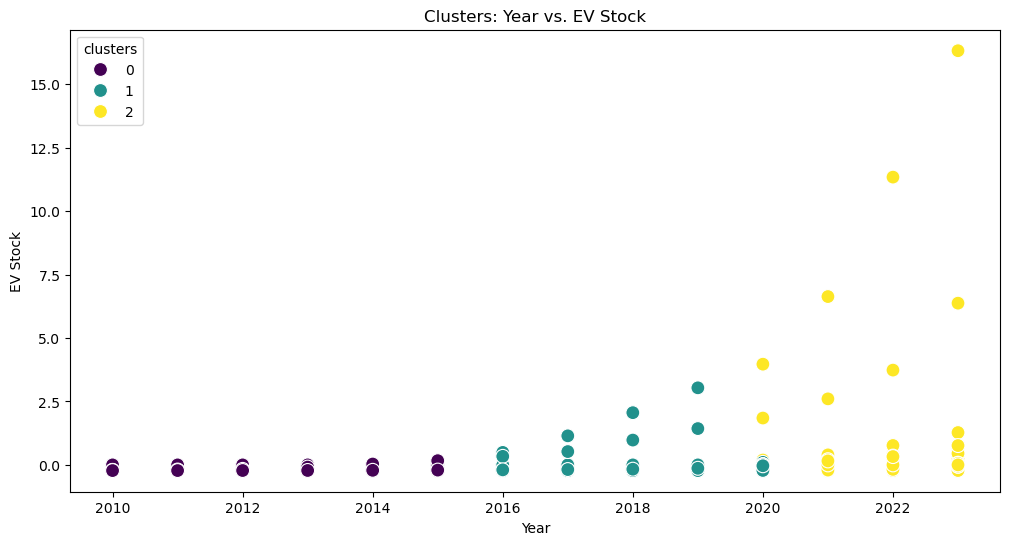

In [29]:
# Scatterplot EV Sales vs. EV Stock
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_pivot['EV sales'], y=df_pivot['EV stock'], hue=df_pivot['clusters'], palette="viridis", s=100)
plt.xlabel("EV Sales")
plt.ylabel("EV Stock")
plt.title("Clusters: EV Sales vs. EV Stock")
plt.show()

# Scatterplot Year vs. EV Sales
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_pivot['year'], y=df_pivot['EV sales'], hue=df_pivot['clusters'], palette="viridis", s=100)
plt.xlabel("Year")
plt.ylabel("EV Sales")
plt.title("Clusters: Year vs. EV Sales")
plt.show()

# Scatterplot Year vs. EV Stock
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_pivot['year'], y=df_pivot['EV stock'], hue=df_pivot['clusters'], palette="viridis", s=100)
plt.xlabel("Year")
plt.ylabel("EV Stock")
plt.title("Clusters: Year vs. EV Stock")
plt.show()


## 7. Discussion of the Clusters:
- **Cluster 0** seems to be from earlier markets, with a lower stock of EVs and fewer sales, showing slower adoption.
- **Cluster 1** is from more mature markets, with higher EV stock and sales, indicating steady growth in EV adoption over time.
- **Cluster 2** represents newer, rapidly expanding markets, with significantly higher sales and stock, showing that these areas are experiencing fast adoption of electric vehicles.

## 8. Areas for Improvement:
- **More features for differentiation**: It could help to incorporate other factors such as government incentives or infrastructure developments (e.g., charging stations) to better differentiate between the clusters.
- **Adjusting the number of clusters**: It might be helpful to further refine the number of clusters. A slight adjustment might result in clearer separation, as **Cluster 2** and **Cluster 1** may overlap in some areas.


## 9. Calculate descriptive statistics for clusters

In [39]:
# Focused summary on key numerical variables
df_pivot.groupby('clusters')[['EV sales', 'EV stock']].agg(['mean', 'std', 'min', 'max'])


parameter  EV sales                                 EV stock            \
               mean       std       min        max      mean       std   
clusters                                                                 
0         -0.155543  0.071899 -0.182120   0.433891 -0.187644  0.082665   
1         -0.100077  0.314653 -0.182076   2.536578 -0.080528  0.318751   
2          0.346573  1.863296 -0.181726  15.442916  0.356979  1.857419   

parameter                       
                min        max  
clusters                        
0         -0.229543   0.166346  
1         -0.229351   3.036522  
2         -0.226468  16.317313

In [41]:
# Count how many data points are in each cluster
df_pivot['clusters'].value_counts()


clusters
1    225
0    185
2    148
Name: count, dtype: int64

## 9. Descriptive Statistics for Clusters

- **Cluster 0**:
  - **EV Sales**: Mean = -0.155543, Min = -0.182120, Max = 0.433891
  - **EV Stock**: Mean = -0.187644, Min = -0.229543, Max = 0.166346
- **Cluster 1**:
  - **EV Sales**: Mean = -0.100077, Min = -0.182076, Max = 2.536578
  - **EV Stock**: Mean = -0.080528, Min = -0.229351, Max = 3.036522
- **Cluster 2**:
  - **EV Sales**: Mean = 0.346573, Min = -0.181726, Max = 15.442916
  - **EV Stock**: Mean = 0.356979, Min = -0.226468, Max = 16.317313

### Findings:
- **Cluster 0** represents markets with lower EV sales and stock, indicating that these are likely early markets with slower adoption.
- **Cluster 1** shows more mature markets with steady growth in EV sales and stock.
- **Cluster 2** is characterized by rapidly expanding markets with higher EV stock and sales, indicating fast-growing adoption.


## 10. Proposed Use of Results for Future Analytics

These clustering results can be a springboard for a wide range of analytics-driven initiatives, from policy design and market strategies to infrastructure planning and environmental impact assessments. By integrating these insights into the next steps of the analytics pipeline—such as predictive modeling, geospatial analysis, and competitive benchmarking—stakeholders can make data-driven decisions to accelerate EV adoption, optimize resources, and achieve sustainability goals.
